In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
onehot_encoder = OneHotEncoder(sparse_output=False)
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import time

## Problem definition

### Definition of loss, softmax and gradient functions.

In [2]:
def loss(X, W, labels):
    m = X.shape[0]

    Z = np.dot(X, W)

    exp_Z = np.exp(Z)
    exp_term = np.sum(exp_Z, axis=1)

    # Here rel_Z means each position of the dot product which corresponds to A[i, :] * X[:, labels[i]]
    rel_Z = Z[np.arange(m), labels]
    loss_value = -np.sum(rel_Z) + np.sum(np.log(exp_term))

    return loss_value

In [3]:
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape((-1,1)))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [4]:
def gradient(X, W, labels):
  preds = softmax(X @ W)
  gradient = X.T @ (labels - preds)
  return gradient

### Definition of Armijo line search

In [5]:
def armijo(X, W, labels, labels_encoded, initial_step=1, delta=0.5, gamma=0.25):
  W_arm = W.copy()
  grad = gradient(X, W_arm, labels_encoded)

  i = 0
  alpha = np.power(delta, i) * initial_step

  W_upd = W_arm + alpha * grad

  while loss(X, W_upd, labels) > loss(X, W_arm, labels) + alpha * gamma * np.linalg.norm(grad):
    i += 1
    alpha = np.power(delta, i) * initial_step
    W_upd = W_upd - alpha * grad
  return alpha

### Definition of prediction and evaluation function

In [6]:
def predict(X, W_upd):
    Z = X @ W_upd
    P = softmax(Z)
    return np.argmax(P, axis=1)

def evaluate(X, W_upd, y):
  y_pred = predict(X, W_upd)
  return (y == y_pred).sum() / len(y)

## Algorithms

### Gradient Descent

In [24]:
def GD(X, labels, lr=0.001, line_search='fixed', tol=1e-4, tol_level=10, max_iter=1500):
  try:
    line_search == 'fixed' or 'armijo'
  except:
    print('Line search you chose is not available. Try "fixed" (default) or "armijo".')

  labels_encoded = onehot_encoder.fit_transform(labels.reshape(-1, 1))
  W = np.random.normal(size=(X.shape[1], len(np.unique(labels))))

  iteration = 0
  losses = list()
  accuracies = list()

  error_counter = 0

  while iteration < max_iter:
    iteration += 1
    learning_rate = lr if line_search == 'fixed' else armijo(X, W, labels, labels_encoded)
    W += learning_rate * gradient(X, W, labels_encoded)
    losses.append(loss(X, W, labels))
    accuracies.append(evaluate(X, W, labels))
    if iteration > 1 and (losses[-2] - losses[-1]) < tol:
      error_counter += 1
    else:
      error_counter = 0

    if error_counter == tol_level:
      break


  return W, losses, accuracies

### Block Coordinate Gradient Descent - Gauss Southwell

In [23]:
def BCGD_GS(X, labels, lr=0.001, tol=1e-4, line_search='fixed', tol_level=10, max_iter=1500):

  try:
    line_search == 'fixed' or 'armijo'
  except:
    print('Line search you chose is not available. Try "fixed" (default) or "armijo".')

  labels_encoded = onehot_encoder.fit_transform(labels.reshape(-1, 1))
  W = np.random.normal(size=(X.shape[1], len(np.unique(labels))))
  losses = list()
  accuracies = list()

  error_counter = 0
  iteration = 0

  for i in range(max_iter):
    iteration += 1
    grad = gradient(X, W, labels_encoded)
    update_ind = np.argmax(np.linalg.norm(grad, axis=1))
    learning_rate = lr if line_search == 'fixed' else armijo(X, W, labels, labels_encoded)
    W[update_ind, :] += learning_rate * grad[update_ind, :]
    losses.append(loss(X, W, labels))
    accuracies.append(evaluate(X, W, labels))

    if iteration > 1 and (losses[-2] - losses[-1]) < tol:
      error_counter += 1
    else:
      error_counter = 0

    if error_counter == tol_level:
      break

  return W, losses, accuracies

## Analysis

### Loss and accuracy analysis

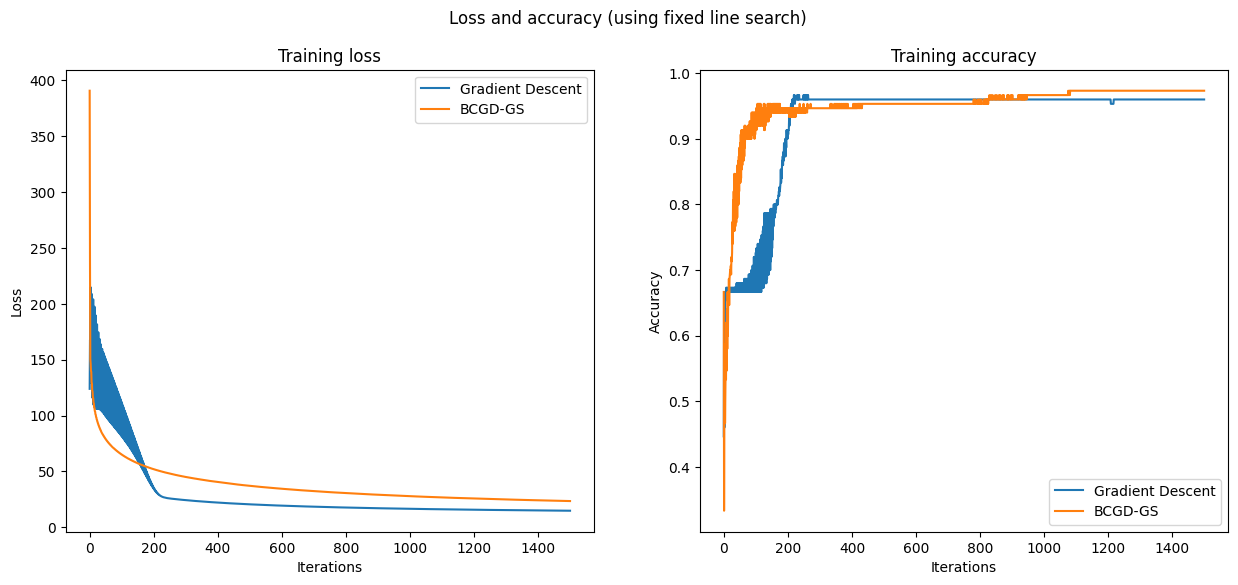

In [9]:
X, y = load_iris().data, load_iris().target

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title('Training loss')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.set_title('Training accuracy')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")

fig.suptitle("Loss and accuracy (using fixed line search)")

W_gd, loss_gd, accuracy_gd = GD(X, y);

W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y);

ax1.plot(range(len(loss_gd)), loss_gd, label='Gradient Descent')
ax1.plot(range(len(loss_bcgd)), loss_bcgd, label='BCGD-GS')

ax2.plot(range(len(accuracy_gd)), accuracy_gd, label='Gradient Descent')
ax2.plot(range(len(accuracy_bcgd)), accuracy_bcgd, label='BCGD-GS')

ax1.legend(loc='best');
ax2.legend(loc='best');

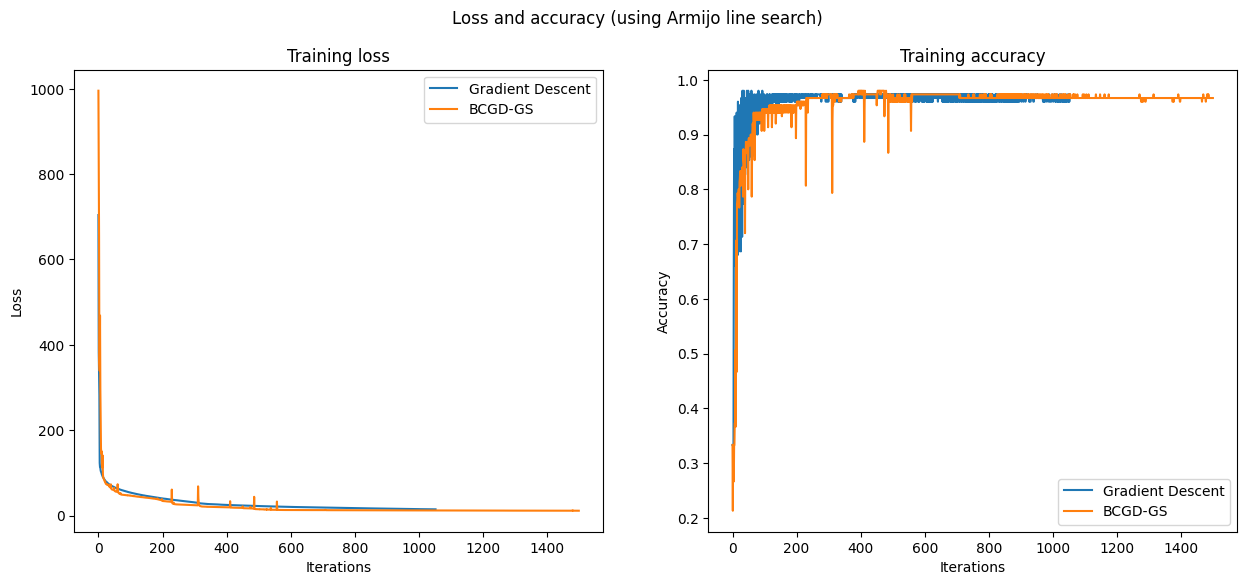

In [10]:
X, y = load_iris().data, load_iris().target

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title('Training loss')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.set_title('Training accuracy')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")

fig.suptitle("Loss and accuracy (using Armijo line search)")

W_gd, loss_gd, accuracy_gd = GD(X, y, line_search='armijo');

W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y, line_search='armijo');

ax1.plot(range(len(loss_gd)), loss_gd, label='Gradient Descent')
ax1.plot(range(len(loss_bcgd)), loss_bcgd, label='BCGD-GS')

ax2.plot(range(len(accuracy_gd)), accuracy_gd, label='Gradient Descent')
ax2.plot(range(len(accuracy_bcgd)), accuracy_bcgd, label='BCGD-GS')

ax1.legend(loc='best');
ax2.legend(loc='best');

### CPU Time analysis

In [16]:
cpu_time_gd = list()
for _ in range(100):
  time_gd1 = time.time()
  W_gd, loss_gd, accuracy_gd = GD(X, y);
  time_gd2 = time.time()
  diff_gd = time_gd2 - time_gd1
  cpu_time_gd.append(diff_gd)

cpu_time_bcgd = list()
for _ in range(100):
  time_bcgd1 = time.time()
  W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y);
  time_bcgd2 = time.time()
  diff_bcgd = time_bcgd2 - time_bcgd1
  cpu_time_bcgd.append(diff_bcgd)

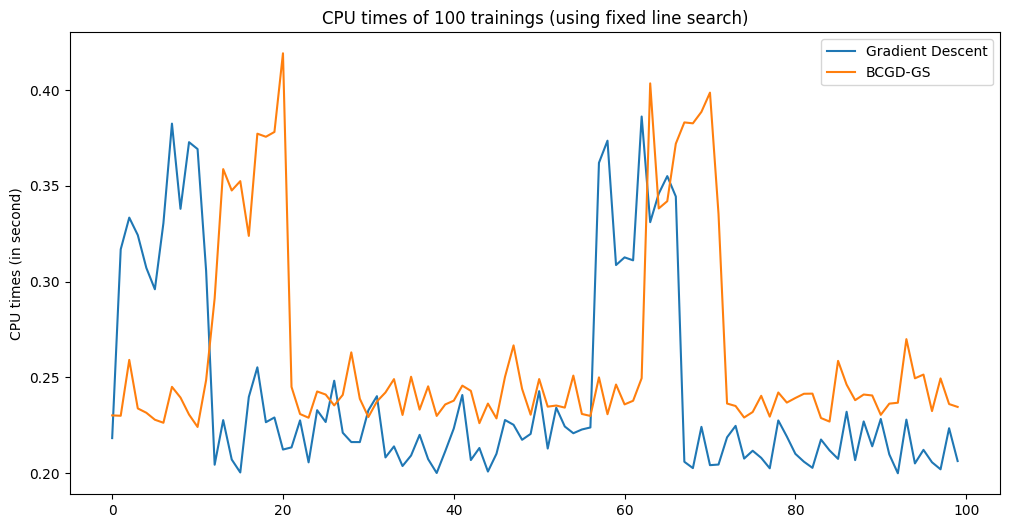

In [17]:
plt.figure(figsize=(12, 6))
plt.title("CPU times of 100 trainings (using fixed line search)")
plt.ylabel("CPU times (in second)")

plt.plot(range(len(cpu_time_gd)), cpu_time_gd, label="Gradient Descent")
plt.plot(range(len(cpu_time_bcgd)), cpu_time_bcgd, label="BCGD-GS")

plt.legend(loc='best')

In [18]:
print(f"Average CPU time for Gradient Descent for Iris dataset using fixed line search: {np.average(cpu_time_gd):.2f}")
print(f"Average CPU time for BCGD-GS for Iris dataset using fixed line search: {np.average(cpu_time_bcgd):.2f}")

Average CPU time for Gradient Descent for Iris dataset using fixed line search: 0.24
Average CPU time for BCGD-GS for Iris dataset using fixed line search: 0.24


In [19]:
cpu_time_gd = list()
for _ in range(100):
  time_gd1 = time.time()
  W_gd, loss_gd, accuracy_gd = GD(X, y, line_search='armijo');
  time_gd2 = time.time()
  diff_gd = time_gd2 - time_gd1
  cpu_time_gd.append(diff_gd)

cpu_time_bcgd = list()
for _ in range(100):
  time_bcgd1 = time.time()
  W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y, line_search='armijo');
  time_bcgd2 = time.time()
  diff_bcgd = time_bcgd2 - time_bcgd1
  cpu_time_bcgd.append(diff_bcgd)

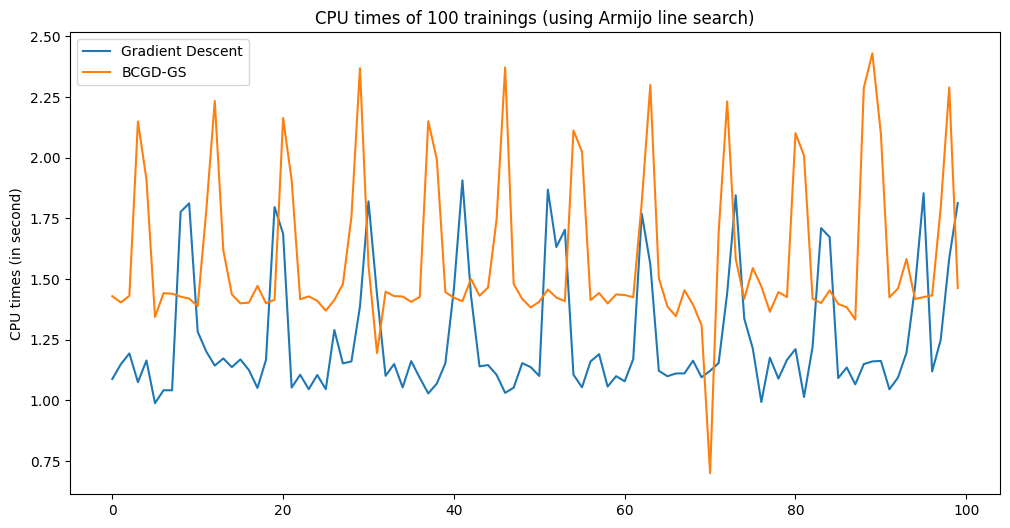

In [21]:
plt.figure(figsize=(12, 6))
plt.title("CPU times of 100 trainings (using Armijo line search)")
plt.ylabel("CPU times (in second)")

plt.plot(range(len(cpu_time_gd)), cpu_time_gd, label="Gradient Descent")
plt.plot(range(len(cpu_time_bcgd)), cpu_time_bcgd, label="BCGD-GS")

plt.legend(loc='best')

In [22]:
print(f"Average CPU time for Gradient Descent for Iris dataset using fixed line search: {np.average(cpu_time_gd):.2f}")
print(f"Average CPU time for BCGD-GS for Iris dataset using fixed line search: {np.average(cpu_time_bcgd):.2f}")

Average CPU time for Gradient Descent for Iris dataset using fixed line search: 1.25
Average CPU time for BCGD-GS for Iris dataset using fixed line search: 1.25


In [40]:
import pandas as pd

data = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")

In [41]:
data.drop(columns=["Bean ID"], inplace=True)

In [28]:
data = data.sample(frac=0.2)

In [42]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

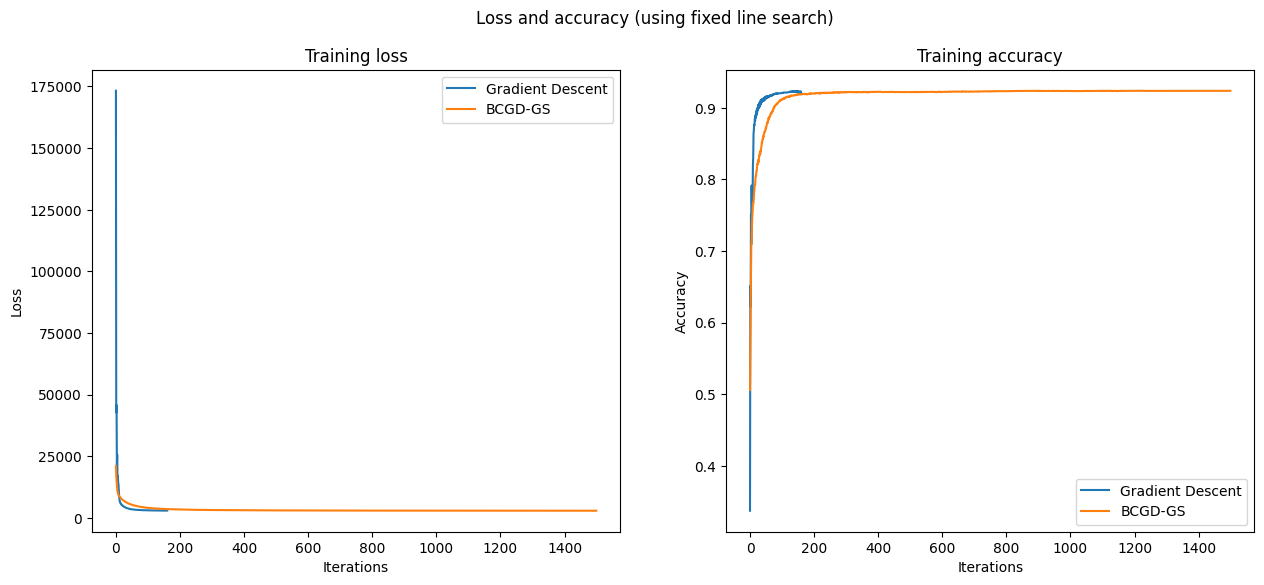

In [45]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title('Training loss')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.set_title('Training accuracy')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")

fig.suptitle("Loss and accuracy (using fixed line search)")

W_gd, loss_gd, accuracy_gd = GD(X, y);

W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y);

ax1.plot(range(len(loss_gd)), loss_gd, label='Gradient Descent')
ax1.plot(range(len(loss_bcgd)), loss_bcgd, label='BCGD-GS')

ax2.plot(range(len(accuracy_gd)), accuracy_gd, label='Gradient Descent')
ax2.plot(range(len(accuracy_bcgd)), accuracy_bcgd, label='BCGD-GS')

ax1.legend(loc='best');
ax2.legend(loc='best');

In [48]:
cpu_time_gd = list()
for _ in range(15):
  time_gd1 = time.time()
  W_gd, loss_gd, accuracy_gd = GD(X, y);
  time_gd2 = time.time()
  diff_gd = time_gd2 - time_gd1
  cpu_time_gd.append(diff_gd)

cpu_time_bcgd = list()
for _ in range(15):
  time_bcgd1 = time.time()
  W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X, y);
  time_bcgd2 = time.time()
  diff_bcgd = time_bcgd2 - time_bcgd1
  cpu_time_bcgd.append(diff_bcgd)

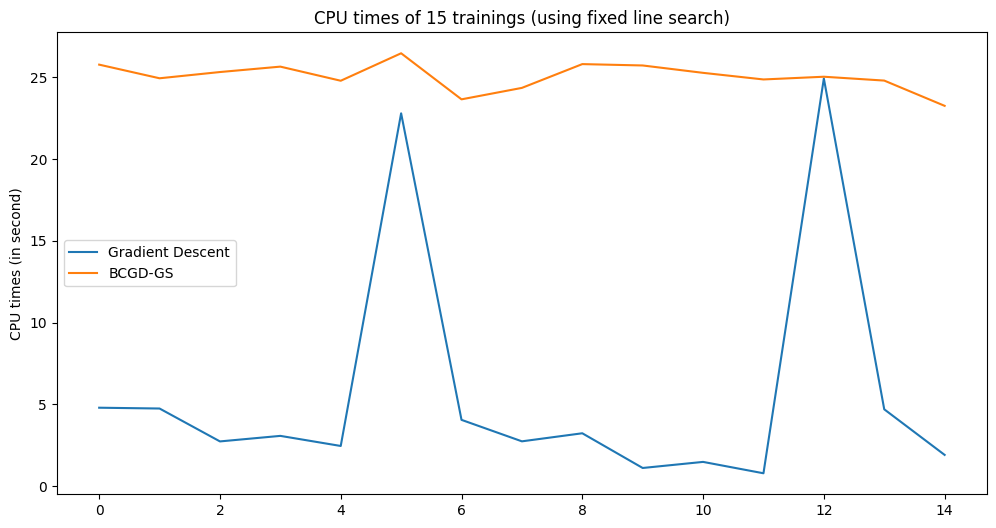

In [49]:
plt.figure(figsize=(12, 6))
plt.title("CPU times of 15 trainings (using fixed line search)")
plt.ylabel("CPU times (in second)")

plt.plot(range(len(cpu_time_gd)), cpu_time_gd, label="Gradient Descent")
plt.plot(range(len(cpu_time_bcgd)), cpu_time_bcgd, label="BCGD-GS")

plt.legend(loc='best')

In [64]:
print(f"Average CPU time for Gradient Descent for Dry Beans dataset using fixed line search: {np.average(cpu_time_gd):.2f}")
print(f"Average CPU time for BCGD-GS for Dry Beans dataset using fixed line search: {np.average(cpu_time_bcgd):.2f}")

Average CPU time for Gradient Descent for Dry Beans dataset using fixed line search: 5.70
Average CPU time for BCGD-GS for Dry Beans dataset using fixed line search: 25.05


In [17]:
import pandas as pd

red_wine = pd.read_csv("/content/winequality-red.csv", delimiter=';')
white_wine = pd.read_csv("/content/winequality-white.csv", delimiter=';')

data = pd.concat([red_wine, white_wine], ignore_index=True)

X = data.drop(columns=['quality'])
y = data.loc[:, 'quality']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy() - 3
y_test = y_test.to_numpy() - 3

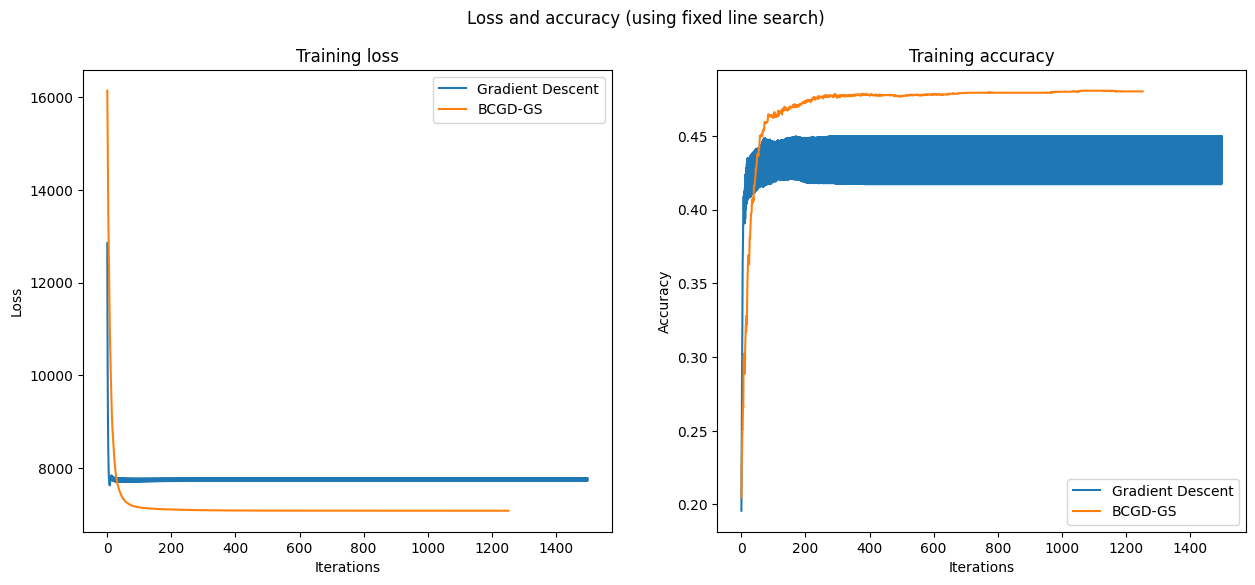

In [26]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.set_title('Training loss')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.set_title('Training accuracy')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")

fig.suptitle("Loss and accuracy (using fixed line search)")

W_gd, loss_gd, accuracy_gd = GD(X_train, y_train);

W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X_train, y_train);

ax1.plot(range(len(loss_gd)), loss_gd, label='Gradient Descent')
ax1.plot(range(len(loss_bcgd)), loss_bcgd, label='BCGD-GS')

ax2.plot(range(len(accuracy_gd)), accuracy_gd, label='Gradient Descent')
ax2.plot(range(len(accuracy_bcgd)), accuracy_bcgd, label='BCGD-GS')

ax1.legend(loc='best');
ax2.legend(loc='best');

In [27]:
evaluate(X_test, W_gd, y_test)

0.4233100233100233

In [28]:
evaluate(X_test, W_bcgd, y_test)

0.4512820512820513

In [29]:
cpu_time_gd = list()
for _ in range(20):
  time_gd1 = time.time()
  W_gd, loss_gd, accuracy_gd = GD(X_train, y_train);
  time_gd2 = time.time()
  diff_gd = time_gd2 - time_gd1
  cpu_time_gd.append(diff_gd)

cpu_time_bcgd = list()
for _ in range(20):
  time_bcgd1 = time.time()
  W_bcgd, loss_bcgd, accuracy_bcgd = BCGD_GS(X_train, y_train);
  time_bcgd2 = time.time()
  diff_bcgd = time_bcgd2 - time_bcgd1
  cpu_time_bcgd.append(diff_bcgd)

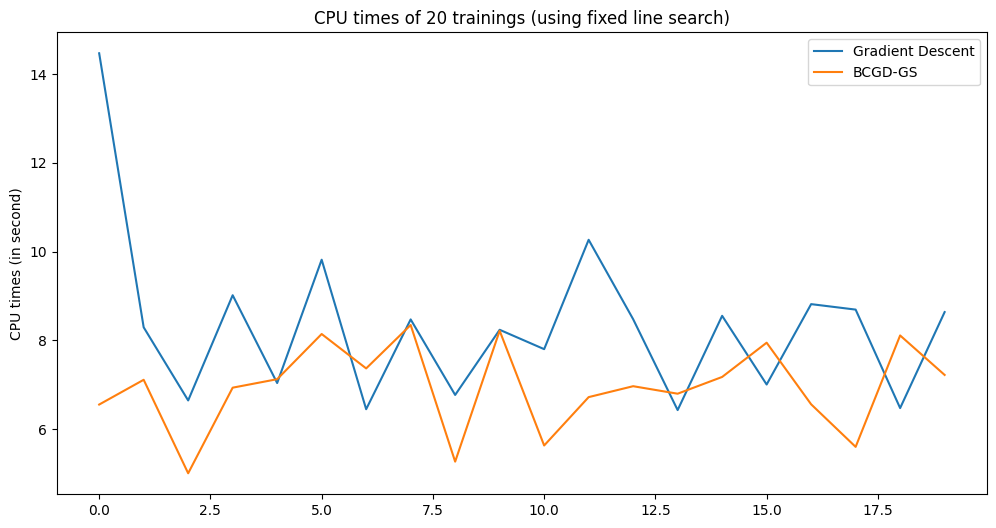

In [30]:
plt.figure(figsize=(12, 6))
plt.title("CPU times of 20 trainings (using fixed line search)")
plt.ylabel("CPU times (in second)")

plt.plot(range(len(cpu_time_gd)), cpu_time_gd, label="Gradient Descent")
plt.plot(range(len(cpu_time_bcgd)), cpu_time_bcgd, label="BCGD-GS")

plt.legend(loc='best')

In [31]:
print(f"Average CPU time for Gradient Descent for Wine Quality dataset using fixed line search: {np.average(cpu_time_gd):.2f}")
print(f"Average CPU time for BCGD-GS for Wine quality dataset using fixed line search: {np.average(cpu_time_bcgd):.2f}")

Average CPU time for Gradient Descent for Wine Quality dataset using fixed line search: 8.32
Average CPU time for BCGD-GS for Wine quality dataset using fixed line search: 6.94
